In [321]:
from qiskit import QuantumCircuit, transpile
import numpy as np
from qiskit.quantum_info.operators import Operator
from qiskit.quantum_info import Statevector, state_fidelity, partial_trace
from scipy.linalg import expm
import matplotlib.pyplot as plt
from qiskit.quantum_info import Kraus, SuperOp
from qiskit.visualization import plot_histogram
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_aer import AerSimulator
 
# Import from Qiskit Aer noise module
from qiskit_aer.noise import (
    NoiseModel,
    QuantumError,
    ReadoutError,
    depolarizing_error,
    pauli_error,
    thermal_relaxation_error,
)


##### First we define some helping functions

In [266]:
# flattening functions to go from 2d lattice point to qubit number in the way i texted in the group about
def lattice_to_qubit(i, j, N):
    return i*N + j

# inverse transformation
def qubit_to_lattice(q, N):
    i = q // N
    j = q % N
    return i, j

# function to get neighbors of given point in qubit index
def get_neighbors(i, j, N):
    neighbors = []
    
    # Check top neighbor (i-1, j)
    if i - 1 >= 0:
        neighbors.append(lattice_to_qubit(i - 1, j, N))
    
    # Check bottom neighbor (i+1, j)
    if i + 1 < N:
        neighbors.append(lattice_to_qubit(i + 1, j, N))
    
    # Check left neighbor (i, j-1)
    if j - 1 >= 0:
        neighbors.append(lattice_to_qubit(i, j - 1, N))
    
    # Check right neighbor (i, j+1)
    if j + 1 < N:
        neighbors.append(lattice_to_qubit(i, j + 1, N))
    
    return neighbors

# function to get the commuting groups for the W operator
def find_groups(lattice_size):
    # List to store groups of nearest neighbors
    groups = [[], [], [], []]
    
    # Iterate over all lattice points
    for x in range(lattice_size):
        for y in range(lattice_size):
            # Determine the parity of x and y
            parity_x = x % 2
            parity_y = y % 2
            
            # Find the right neighboring points (right and up)
            if x + 1 < lattice_size:  # Right neighbor
                if  parity_x == 0:
                    groups[0].append(([x, y], [x + 1, y]))
                else:
                    groups[1].append(([x, y], [x + 1, y]))
            
            if y+1 < lattice_size:  # Up neighbor
                if parity_y == 0:
                    groups[2].append(([x, y], [x, y + 1]))
                else:
                    groups[3].append(([x, y], [x, y + 1]))
    
    # Return the groups ordered by your specified parity rule
    return groups


# digital gate trotterization of the W operator
def W(qc, t, M, J_matrix, g_matrix):
    for _ in range(M):
        # applying the Z rotation
        for i in range(int(np.sqrt(qc.num_qubits -1))):
            for j in range(int(np.sqrt(qc.num_qubits -1))):
                q = lattice_to_qubit(i, j, int(np.sqrt(qc.num_qubits -1))) 
                qc.rz(J_matrix[i,j] * t /(M) , q +1)
        # applying the XX and YY rotations
        groups = find_groups(int(np.sqrt(qc.num_qubits -1)))
        for k in range(2):
            for group in groups:
                if group == []:
                    continue
                for pairs in group:
                    q1 = lattice_to_qubit(pairs[0][0], pairs[0][1], int(np.sqrt(qc.num_qubits -1))) 
                    q2 = lattice_to_qubit(pairs[1][0], pairs[1][1], int(np.sqrt(qc.num_qubits -1))) 
                    angle = g_matrix[q1, q2] * t / (2*M)
                    if k == 0:
                        qc.rxx(angle, q1 +1, q2 +1)
                    if k == 1:
                        qc.ryy(angle, q1 +1, q2 +1)
            


In [368]:
# defining pauli matrices
I = np.eye(2)
X = np.array([[0, 1], [1, 0]])
Y = np.array([[0, -1j], [1j, 0]])
Z = np.array([[1, 0], [0, -1]])

# function for pauli chain with I and X in indexed spots
def xixj(index1,index2,N):
    if index1 == 0 or index2 == 0:
        result = X
    else:
        result = I
    for i in range(1,N):
        if i == index1 or i == index2:
            result = np.kron(result,X)
        else:
            result = np.kron(result, I)
    return result

# function for pauli chain with I and Y in indexed spots
def yiyj(index1,index2,N):
    if index1 == 0 or index2 == 0:
        result = Y
    else:
        result = I
    for i in range(1,N):
        if i == index1 or i == index2:
            result = np.kron(result,Y)
        else:
            result = np.kron(result, I)
    return result

# function for pauli chain with I and Z in indexed spot
def zi(index,N):
    if index == 0:
        result = Z
    else:
        result = I
    for i in range(1,N):
        if i == index:
            result = np.kron(result,Z)
        else:
            result = np.kron(result, I)
    return result

# making a function for the XY model hamiltonian H
def Hamiltonian_unitary(J_matrix, g_matrix,N):
    H = np.zeros((2**(N**2), 2**(N**2)), dtype=np.complex128)
    interaction_count = [] # keeping track of pairs to only ocunt once
    for i in range(N):
        for j in range(N):
            q = lattice_to_qubit(i,j,N)
            H += J_matrix[qubit_to_lattice(q,N)]*zi(q,N**2) # adding onsite potential
            neighbors = get_neighbors(i,j, N) # getting nearest neighbors without periodic boundaries
            for neighbor in neighbors:
                q1 = lattice_to_qubit(i, j, N) # mapping to qubits with chessboard pattern
                q2 = neighbor
                if (q1,q2) not in interaction_count: # checking if the pair has already been counted
                    H += g_matrix[q1, q2]*xixj(q1,q2,N**2)/2 # applying the X term
                    H += g_matrix[q1, q2]*yiyj(q1,q2,N**2)/2 # applying the Y term
                    interaction_count.append((q2,q1))
                    # print(q1,q2)
    
    return H


def Ham_evo(H, t):
    if t%2 == 0: # to ensure alternatiion between W(1/2) and W(-1/2)
        op = Operator(expm(-1j*H/2))
        return op
    else:
        op = Operator(expm(1j*H/2))
        return op

def H_sh(H, eta):
    diag = np.linalg.eigvalsh(H)
    c_1 = (np.pi - 2*eta)/(np.max(diag)-np.min(diag))
    c_2 = eta - c_1*np.min(diag)
    return c_1 * H + c_2 * np.eye(len(diag))

In [306]:
def analog_qetu(phi, N, H, num_applications):
    # creating a quantum circuit with NxN qubits and one ancilla qubit
    qc = QuantumCircuit(N**2 + 1)

    # initializing superposition state
    for i in range(N**2):
        qc.h(i+1)

    for _ in range(num_applications):
        
        for i in range(len(phi)-1):
            # applying the x rotation by the phase to the ancilla qubit
            qc.rx(phi[i], 0)

            # applying the controlled K string of pauli operators
            for j in range(int(N**2)): 
                if j%2 == 0:
                    qc.cx(0, j+1)
                if j%2 == 1:
                    qc.cy(0, j+1)
            
            # applying the hamiltonian evolution
            qc.append(Ham_evo(H, i), range(1,N**2+1))
            
            # applying the k-string again

            for j in range(int(N**2)):
                if j%2 == 0:
                    qc.cx(0, j+1)
                if j%2 == 1:
                    qc.cy(0, j+1)
            
        # applying the last x rotation
        qc.rx(phi[-1], 0)

    return qc

def digital_qetu(phi, N, t, M, J_matrix, g_matrix):
    # creating a quantum circuit with NxN qubits and one ancilla qubit
    qc = QuantumCircuit(N**2 + 1)
    
    for i in range(len(phi)-1):
        # applying the x rotation by the phase to the ancilla qubit
        qc.rx(phi[i], 0)

        # applying the controlled K string of pauli operators
        for i in range(int(N**2)): 
            if i%2 == 0:
                qc.cx(0, i+1)
            if i%2 == 1:
                qc.cy(0, i+1)

        qc.barrier()
        
        # applying the hamiltonian evolution
        W(qc, t, M, J_matrix, g_matrix)

        qc.barrier()
        
        # applying the k-string again

        for i in range(int(N**2)):
            if i%2 == 0:
                qc.cx(0, i+1)
            if i%2 == 1:
                qc.cy(0, i+1)
        
    # applying the last x rotation
    qc.rx(phi[-1], 0)

    return qc


<IPython.core.display.Latex object>

In [367]:
N = 2
eta = 0.01

J_test = 1*np.ones((N,N))
G_test = 1*np.ones((N**2,N**2))

H = Hamiltonian_unitary(J_test, G_test, N)

H2 = H_sh(H, eta = eta)
eigvals, eigvecs = np.linalg.eig(H2)
min_ind = np.argmin(eigvals)
target_state = Statevector(eigvecs[min_ind]/(np.linalg.norm(eigvecs[min_ind])))
target_state.draw('latex')
print(eigvals)

[1.57079633+0.j 0.79039816+0.j 0.01      +0.j 3.13159265+0.j
 2.35119449+0.j 0.46714666+0.j 1.57079633+0.j 2.67444599+0.j
 2.35119449+0.j 1.57079633+0.j 0.79039816+0.j 1.57079633+0.j
 1.57079633+0.j 1.57079633+0.j 3.13159265+0.j 0.01      +0.j]


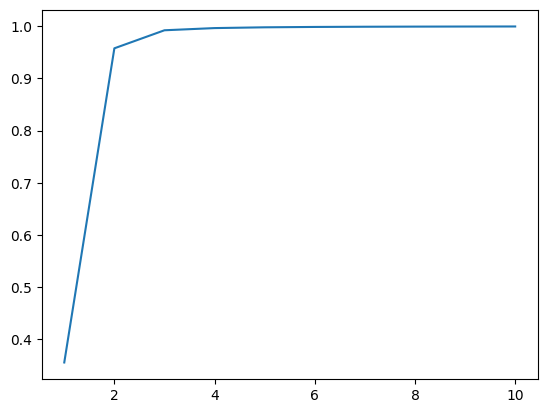

In [369]:
t = 1
M = 1
# digital implementation
N = 2
qc = QuantumCircuit(N**2+1)
for i in range(1, N**2 +1):
    qc.h(i)
qc.unitary(Ham_evo(H,0), range(1,N**2+1))
state = Statevector.from_instruction(qc)

# analog implementation
fidelities = []
for i in range(10):
    qc2 = QuantumCircuit(N**2+1)
    for j in range(1, N**2 +1):
        qc2.h(j)
    W(qc2, t,i, J_test, G_test)
    state2 = Statevector.from_instruction(qc2)
    fidelities.append(state_fidelity(state, state2))
plt.plot(np.linspace(1,10,10), fidelities)

CONVERGENCE!!!!

In [353]:
# setting up a noise model for depolarizing noise on our unitary
noise_model = NoiseModel()

error = depolarizing_error(0.05, 4)
noise_model.add_all_qubit_quantum_error(error, ["Ham_evo(H,0)"])
print(noise_model)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx']
  Instructions with noise: ['Ham_evo(H,0)']
  All-qubits errors: ['Ham_evo(H,0)']


In [328]:
phases = np.loadtxt('phases.txt')
qc = analog_qetu(phases, N,H, 1)
state = Statevector.from_instruction(qc)
state = partial_trace(state, [0])
state = np.diagonal(state)/np.linalg.norm(np.diagonal(state))
state = Statevector(state)
print(state_fidelity(state,target_state))

0.12733604158309567
